#### Exercise 1
**Task:** *Train a **trigram** language model, i.e. take two characters as an input to predict the 3rd one.
Feel free to use either counting or a neural net.
Evaluate the loss; Did it improve over a bigram model?*

In [25]:
words = open('names.txt', 'r').read().split()

In [26]:
import torch

In [27]:
a = [ch for w in words for ch in w ]
alphabet = sorted(list(set(a)))
stoi = {s:i+1 for i, s in enumerate(alphabet)}
stoi['.'] = 0

In [28]:
itos = {i:s for s, i, in stoi.items()}

In [29]:
N = torch.zeros((27, 27, 27))
for w in words:
    w = '..' + w + '..'
    for ch1, ch2, ch3 in zip(w, w[1:], w[2:]):
        idx1 = stoi[ch1]
        idx2 = stoi[ch2]
        idx3 = stoi[ch3]
        N[idx1, idx2, idx3] += 1

In [30]:
N /= N.sum(2, keepdim=True)

In [31]:
initial_name = '..'
while True:
    idx1 = stoi[initial_name[-2]]
    idx2 = stoi[initial_name[-1]]
    probs = N[idx1, idx2, :]
    ix = torch.multinomial(probs, num_samples=1, replacement=True).item()
    if ix == 0:
        break
    initial_name += itos[ix]
    print(initial_name)


..d
..de
..des


In [32]:
log_likelihood = 0
n = 0

for w in words:
    w = '..' + w + '..'
    for ch1, ch2, ch3 in zip(w, w[1:], w[2:]):
        idx1 = stoi[ch1]
        idx2 = stoi[ch2]
        idx3 = stoi[ch3]
        prob = N[idx1, idx2, :]
        log_likelihood += torch.log(prob[idx3])
        n += 1

nll = -log_likelihood
nll /= n  

In [33]:
nll

tensor(1.9166)

In [34]:
xs, ys = [], []
for w in words:
    w = '..' + w + '..'
    for ch1, ch2, ch3 in zip(w, w[1:], w[2:]):
        xs.append([stoi[ch1], stoi[ch2]])
        ys.append(stoi[ch3])

In [35]:
import torch.nn.functional as F

xs = torch.tensor(xs)
ys = torch.tensor(ys)

In [36]:
for i in range(5):
    xenc = F.one_hot(xs, num_classes=27).float().view(-1, 54)
    w = torch.randn((54, 27), requires_grad=True)
    logits = xenc @ w
    counts = logits.exp()
    probs = counts / counts.sum(dim=1, keepdim=True)
    loss = -probs[torch.arange(xenc.shape[0]), ys].log().mean()
    w.grad = None
    loss.backward()
    w.data += 50 * w.grad
    print(loss.item())

4.0438761711120605
4.528078556060791
4.233012676239014
4.185505390167236
4.162286281585693


#### Exercise 2
**Task:** *Split up the dataset randomly into 80% train set, 10% dev set, 10% test set.
Train the bigram and trigram models **only** on the training set. 
Evaluate them on dev and test splits. What can you see?*

In [37]:
from random import shuffle

shuffle(words)
size = len(words)
train_len, dev_len = int(size * 0.8), int(size * 0.9)
train, dev, test = words[0:train_len], words[train_len:dev_len], words[dev_len:]

In [38]:
N = torch.zeros((27, 27))
for w in train:
    w = '.' + w + '.'
    for ch1, ch2 in zip(w, w[1:]):
        idx1 = stoi[ch1]
        idx2 = stoi[ch2]
        N[idx1, idx2] += 1
        #print(f'{ch1}{ch2}{ch3}')

In [39]:
N += 1

In [40]:
N /= N.sum(1, keepdim=True)

In [41]:
log_likelihood = 0
n = 0

for w in train:
    w = '.' + w + '.'
    for ch1, ch2 in zip(w, w[1:]):
        idx1 = stoi[ch1]
        idx2 = stoi[ch2]
        prob = N[idx1, idx2]
        log_likelihood += torch.log(prob)
        n += 1

nll = -log_likelihood
nll /= n

In [42]:
nll 

tensor(2.4551)

In [43]:
N = torch.zeros((27, 27, 27))
for w in train:
    w = '..' + w + '..'
    for ch1, ch2, ch3 in zip(w, w[1:], w[2:]):
        idx1 = stoi[ch1]
        idx2 = stoi[ch2]
        idx3 = stoi[ch3]
        N[idx1, idx2, idx3] += 1
        #print(f'{ch1}{ch2}{ch3}')

N += 1
N /= N.sum(2, keepdim=True)
log_likelihood = 0
n = 0

for w in dev + test:
    w = '..' + w + '..'
    for ch1, ch2, ch3 in zip(w, w[1:], w[2:]):
        idx1 = stoi[ch1]
        idx2 = stoi[ch2]
        idx3 = stoi[ch3]
        prob = N[idx1, idx2, idx3]
        log_likelihood += torch.log(prob)
        n += 1

nll = -log_likelihood
nll /= n

In [44]:
nll

tensor(1.9679)

#### Exercise 3 
**Task:** *Use the dev set to tune the strength of smoothing (or regularization) for the trigram model - i.e. try many possibilities and see which one works best based on the dev set loss.
What patterns can you see in the train and dev set loss as you tune this strength?
Take the best setting of the smoothing and evaluate on the test set once and at the end.
How good of a loss do you achieve?*

In [45]:
N_original = torch.zeros((27, 27, 27))
for w in train:
    w = '..' + w + '..'
    for ch1, ch2, ch3 in zip(w, w[1:], w[2:]):
        idx1 = stoi[ch1]
        idx2 = stoi[ch2]
        idx3 = stoi[ch3]
        N_original[idx1, idx2, idx3] += 1
        #print(f'{ch1}{ch2}{ch3}')

all_likelihoods = []
for i in range(1, 100):
    N = N_original.clone()
    N += i
    N /= N.sum(2, keepdim=True)
    log_likelihood = 0
    n = 0

    for w in dev:
        w = '..' + w + '..'
        for ch1, ch2, ch3 in zip(w, w[1:], w[2:]):
            idx1 = stoi[ch1]
            idx2 = stoi[ch2]
            idx3 = stoi[ch3]
            prob = N[idx1, idx2, idx3]
            log_likelihood += torch.log(prob)
            n += 1

    nll = -log_likelihood / n
    all_likelihoods.append(nll)

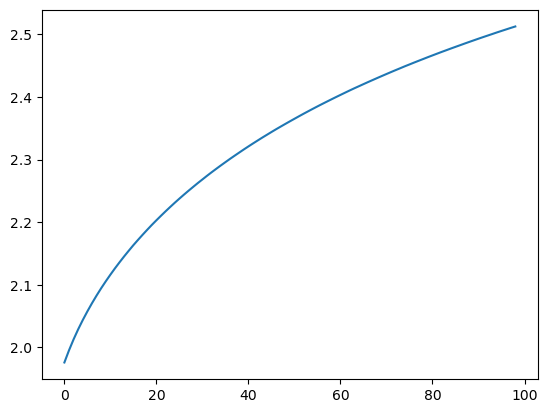

In [46]:
import matplotlib.pyplot as plt

plt.plot(all_likelihoods)

In [47]:
N = N_original.clone()
N += 1
N /= N.sum(2, keepdim=True)
log_likelihood = 0
n = 0
for w in test:
    w = '..' + w + '..'
    for ch1, ch2, ch3 in zip(w, w[1:], w[2:]):
        idx1 = stoi[ch1]
        idx2 = stoi[ch2]
        idx3 = stoi[ch3]
        prob = N[idx1, idx2, idx3]
        log_likelihood += torch.log(prob)
        n += 1
nll = -log_likelihood / n
nll

tensor(1.9599)

#### Exercise 4
**Task:** *we saw that our 1-hot vectors merely select a row of W, so producing these vectors explicitly feels wasteful. Can you delete our use of F.one_hot in favor of simply indexing into rows of W?*

In [48]:
import torch.nn.functional as F

xs, ys = [], []
for w in words:
    w = '.' + w + '.'
    for ch1, ch2 in zip(w, w[1:]):
        xs.append(stoi[ch1])
        ys.append(stoi[ch2])

for i in range(5):
    w = torch.randn((27, 27), requires_grad=True)
    logits = w[xs]
    log_probs = logits.log_softmax(dim=1)
    # probs = counts / counts.sum(dim=1, keepdim=True)
    loss = -log_probs[torch.arange(len(ys)), ys].mean()
    w.grad = None
    loss.backward()
    w.data += -50 * w.grad
    print(loss.item())

3.7896158695220947
3.8526151180267334
3.698849678039551
3.7429211139678955
3.7846245765686035


#### Exercise 5 
**Task:** *look up and use F.cross_entropy instead. You should achieve the same result. Can you think of why we'd prefer to use F.cross_entropy instead?*

In [51]:
import torch.nn.functional as F

xs, ys = [], []
for w in words:
    w = '.' + w + '.'
    for ch1, ch2 in zip(w, w[1:]):
        xs.append(stoi[ch1])
        ys.append(stoi[ch2])

ys = torch.tensor(ys)

for i in range(5):
    w = torch.randn((27, 27), requires_grad=True)
    logits = w[xs]
    loss = F.cross_entropy(logits, ys)
    w.grad = None
    loss.backward()
    w.data += -50 * w.grad
    print(loss.item())

3.751073122024536
3.8466968536376953
3.8136487007141113
3.686424493789673
3.7042577266693115


#### Exercise 6
**Task:** *meta-exercise! Think of a fun/interesting exercise and complete it.*